In [2]:
import numpy as np
import networkx as nx

In [15]:
G = nx.Graph() 

In [16]:
G.add_nodes_from(range(0,6))

In [17]:
G.add_edge(*(0,1))
G.add_edge(*(0,3))
G.add_edge(*(2,1))
G.add_edge(*(3,2))
G.add_edge(*(0,4))
G.add_edge(*(0,5))
G.add_edge(*(4,5))
G.add_edge(*(3,4))

In [18]:
print(nx.minimum_cycle_basis(G))

[[0, 1, 2, 3], [0, 3, 4], [0, 4, 5]]


In [19]:
import matplotlib.pyplot as pl

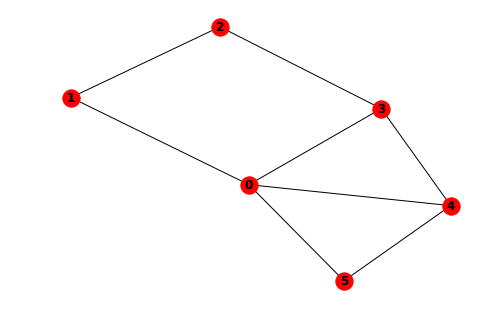

In [20]:
nx.draw(G, with_labels=True, font_weight='bold')

In [21]:
list(G.edges)

[(0, 1), (0, 3), (0, 4), (0, 5), (1, 2), (2, 3), (3, 4), (4, 5)]

In [22]:
G.nodes

NodeView((0, 1, 2, 3, 4, 5))

In [23]:
for e in G.edges:
    print(e)

(0, 1)
(0, 3)
(0, 4)
(0, 5)
(1, 2)
(2, 3)
(3, 4)
(4, 5)


In [44]:
import copy
def reduce_cycle(G, cycle, node_ind=None):
    if not node_ind:
        node_ind = min(cycle)
        
    cycle = set(cycle)
    R = copy.deepcopy(G)
    
    for edge in G.edges:
        if edge[0] in cycle and edge[1] in cycle:
            R.remove_edge(*edge)
        elif edge[0] in cycle:
            R.remove_edge(*edge)
            edge = (node_ind, edge[1])
            R.add_edge(*edge)
        elif edge[1] in cycle:
            R.remove_edge(*edge)
            edge = (edge[0], node_ind)
            R.add_edge(*edge)
    
    for node in cycle:
        if node != node_ind:
            R.remove_node(node)
    return R

In [25]:
print(nx.minimum_cycle_basis(G))

[[0, 1, 2, 3], [0, 3, 4], [0, 4, 5]]


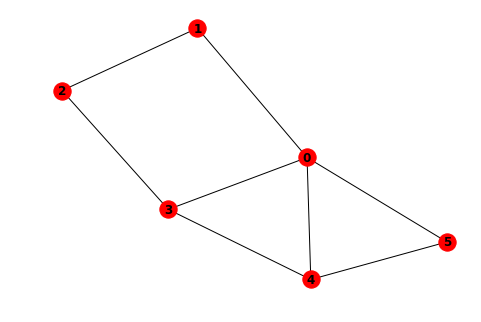

In [26]:
nx.draw(G, with_labels=True, font_weight='bold')

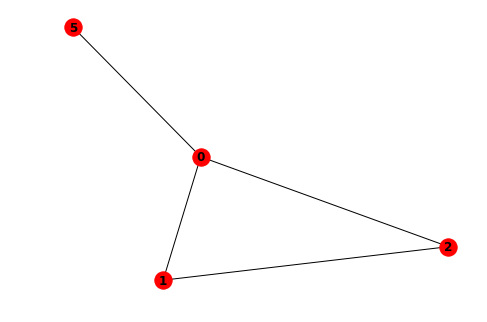

In [27]:
nx.draw(reduce_cycle(G,nx.minimum_cycle_basis(G)[1]) , with_labels=True, font_weight='bold')

In [185]:
import os
class molecule(object):
    def __init__(self):
        self.G = nx.Graph()
        self.prop = []
        self.links = dict()
    
    def get_label(self, ind):
        return self.prop[ind][1]
    def get_pos(self, ind):
        return self.prop[ind][0]
    
def mol_reader(filename):
    if not os.path.isfile(filename):
        print("File {} not exists".format(filename))
        return None
    m = molecule()
    
    f = open(filename, "r")
    f.readline()
    fmt = f.readline().strip()
    f.readline()
    
    meta = f.readline()
    n_atoms, n_links = [int(tmp) for tmp in meta.split(' ')[1:3]]
    m.G.add_nodes_from(range(0, n_atoms))
    
    for i in range(0, n_atoms):
        tmp = f.readline()
        tmp = list(filter(lambda x: x and x != ' ', tmp.split(' ')))
        pos = np.asarray([float(tmp[0]), float(tmp[1]), float(tmp[2])], dtype=np.float64)
        label = tmp[3]
        
        m.prop.append([pos, label])
        
    for i in range(0, n_links):
        tmp = f.readline()
        tmp = list(filter(lambda x: x and x != ' ', tmp.split(' ')))
        tmp = [int(item) for item in tmp]
        m.G.add_edge(tmp[0]-1, tmp[1]-1, weight=tmp[2])        
    return m

In [158]:
m = mol_reader("/Users/r.bomin/src/molecule_descriptors/dataset/2.mol")

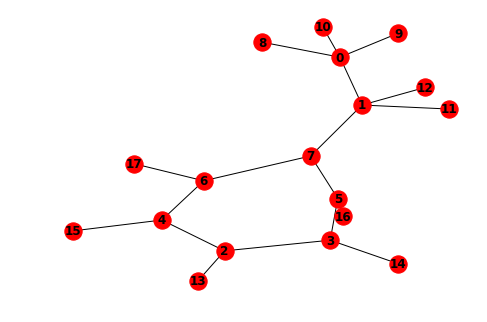

In [30]:
nx.draw(m.G, with_labels=True, font_weight='bold')

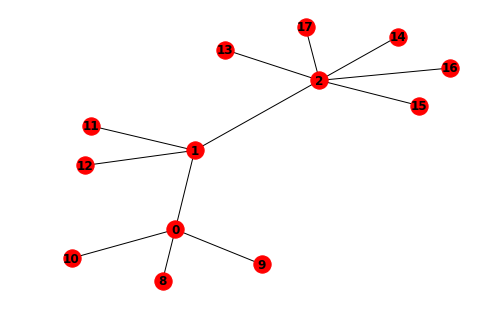

In [31]:
nx.draw(reduce_cycle(m.G,nx.minimum_cycle_basis(m.G)[0]) , with_labels=True, font_weight='bold')

In [151]:
from collections import deque
def unpack_frag(fragments, frag_id):
    if len(fragments[frag_id]) <= 1:
        return fragments[frag_id]
    
    fragment = set()
    fragment_deque = deque(sorted(fragments[frag_id]))
    frag_keys = set(fragments.keys())
        
    while len(fragment_deque) > 0:
        frag = fragment_deque.pop()
        if frag in fragment:
            continue
            
        if frag not in frag_keys:
            fragment.add(frag)
            continue
            
        new_fragments = fragments[frag]
        if len(new_fragments) == 1:
            fragment.add(frag)
        else:
            for frag in new_fragments:
                if frag not in fragment:
                    fragment_deque.appendleft(frag)
    return list(fragment)

In [152]:
def get_fragments(G):
    R = copy.deepcopy(G)
    fragments = dict()
    
    cycles = nx.minimum_cycle_basis(G)
    max_ind = max(G.nodes) + 1
    
    for c in cycles:
        R = reduce_cycle(R, c, node_ind=max_ind)
        fragments[max_ind] = c
        max_ind += 1
        
    n = len(R.nodes())
    
    while n > 1:
        n = len(R.nodes())
        leaf_nodes = set(filter(lambda x: R.degree(x) == 1, R.nodes()))
        parents = set()
        
        fragkeys = set(fragments.keys())
        for leaf in leaf_nodes:
            parents.update(R.neighbors(leaf))
            if leaf not in fragkeys:
                fragments[leaf] = [leaf]
                
        for parent in parents: # Can change while
            parent_leafs = list(filter(lambda x: x in leaf_nodes, R.neighbors(parent)))
            fragments[max_ind] = parent_leafs + [parent]
            
            
            for node in parent_leafs:
                R.remove_node(node)
            
            neighbours = R.neighbors(parent)
            R.remove_node(parent)
            for neighbour in neighbours:
                R.add_edge(neighbour, max_ind)
            
            max_ind += 1
            
    return fragments
    

In [164]:
def code_fragment(molecule, fragment):
    code = []
    for i in fragment:
        code.append(molecule.get_label(i))
        
    frag_graph = molecule.G.subgraph(fragment)
    n_links = sum([d['weight'] for u,v,d in frag_graph.edges(data=True)])
    
    code = "".join(sorted(code)) + str(n_links)
    return code

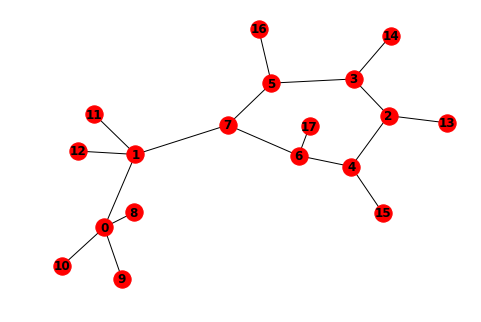

In [165]:
nx.draw(m.G, with_labels=True, font_weight='bold')

In [187]:
data = dict()
for i in range(0, 5):
    m = mol_reader("/Users/r.bomin/src/molecule_descriptors/dataset/{}.mol".format(i))
    fragments = get_fragments(m.G)
    
    codes = dict()
    for frag_id in fragments:
        fragments[frag_id] = unpack_frag(fragments, frag_id)
        codes[frag_id] = code_fragment(m, fragments[frag_id])
    
    data[i] = dict()
    data[i]["mol"] = m
    data[i]["frag"]  = fragments
    data[i]["codes"] = codes

NetworkXError: The node 15 is not in the graph.

In [186]:
m = mol_reader("/Users/r.bomin/src/molecule_descriptors/dataset/{}.mol".format(5))

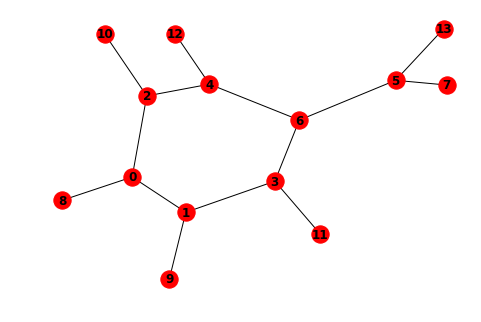

In [190]:
nx.draw(m.G, with_labels=True, font_weight='bold')

In [214]:
def get_fragments2(G):
    R = copy.deepcopy(G)
    fragments = dict()
    
    cycles = nx.minimum_cycle_basis(G)
    max_ind = max(G.nodes) + 1
    
    for c in cycles:
        R = reduce_cycle(R, c, node_ind=max_ind)
        fragments[max_ind] = c
        max_ind += 1
        
    n = len(R.nodes())
    nx.draw(R, with_labels=True, font_weight='bold')
    print(R.edges)
    
    for node in R.nodes():
        print(node, list(R.neighbors(node)))
    n = len(R.nodes())
    leaf_nodes = set(filter(lambda x: R.degree(x) == 1, R.nodes()))
    parents = set()
        
    fragkeys = set(fragments.keys())
    for leaf in leaf_nodes:
        parents.update(R.neighbors(leaf))
        if leaf not in fragkeys:
            fragments[leaf] = [leaf]
                
    for parent in parents:
        parent_leafs = list(filter(lambda x: x in leaf_nodes, R.neighbors(parent)))
        fragments[max_ind] = parent_leafs + [parent]
        
        for node in parent_leafs:
            R.remove_node(node)
            
            
        neighbours = R.neighbors(parent)
        R.remove_node(parent)
        for neighbour in neighbours:
            R.add_edge(neighbour, max_ind)
            
        max_ind += 1
        
    n = len(R.nodes())
    nx.draw(R, with_labels=True, font_weight='bold')
    print(R.edges)
    
    for node in R.nodes():
        print(node, list(R.neighbors(node)))
    n = len(R.nodes())
    leaf_nodes = set(filter(lambda x: R.degree(x) == 1, R.nodes()))
    parents = set()
        
    fragkeys = set(fragments.keys())
    for leaf in leaf_nodes:
        parents.update(R.neighbors(leaf))
        if leaf not in fragkeys:
            fragments[leaf] = [leaf]
                
    for parent in parents:
        parent_leafs = list(filter(lambda x: x in leaf_nodes, R.neighbors(parent)))
        fragments[max_ind] = parent_leafs + [parent]
        
        for node in parent_leafs:
            R.remove_node(node)
            
        neighbours = R.neighbors(parent)
        R.remove_node(parent)
        for neighbour in neighbours:
            R.add_edge(neighbour, max_ind)
            
        max_ind += 1

[(5, 7), (5, 13), (5, 14), (8, 14), (9, 14), (10, 14), (11, 14), (12, 14)]
5 [7, 13, 14]
7 [5]
8 [14]
9 [14]
10 [14]
11 [14]
12 [14]
13 [5]
14 [8, 9, 10, 11, 12, 5]
[(15, 16)]
15 [16]
16 [15]


NetworkXError: The node 15 is not in the graph.

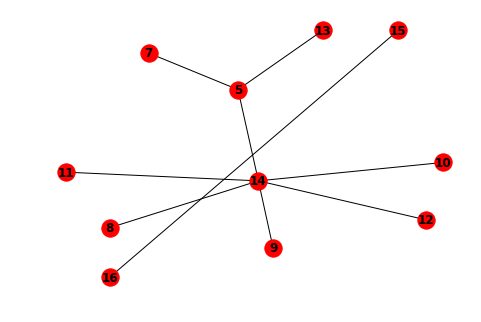

In [215]:
fragments = get_fragments2(m.G)
print(fragments)

In [ ]:
while n > 1:
        n = len(R.nodes())
        leaf_nodes = set(filter(lambda x: R.degree(x) == 1, R.nodes()))
        parents = set()
        
        fragkeys = set(fragments.keys())
        for leaf in leaf_nodes:
            parents.update(R.neighbors(leaf))
            if leaf not in fragkeys:
                fragments[leaf] = [leaf]
                
        for parent in parents:
            parent_leafs = list(filter(lambda x: x in leaf_nodes, R.neighbors(parent)))
            fragments[max_ind] = parent_leafs + [parent]
            
            
            for node in parent_leafs:
                R.remove_node(node)
            
            neighbours = R.neighbors(parent)
            R.remove_node(parent)
            for neighbour in neighbours:
                R.add_edge(neighbour, max_ind)
            
            max_ind += 1
            
    return fragments